In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Import the data
data_file_name = 'ppi_clean'
ppi_clean_train = pd.read_csv(f'data/{data_file_name}_train.csv')
ppi_clean_train

,domain,aa_ProtPosition,uniprot_id,hydrophobicity_scores,Rlength,normalized_length,normalized_abs_surf_acc,normalized_hydropathy_index,rel_surf_acc,prob_sheet,...,9_wm_pssm_K,9_wm_pssm_M,9_wm_pssm_F,9_wm_pssm_P,9_wm_pssm_S,9_wm_pssm_T,9_wm_pssm_W,9_wm_pssm_Y,9_wm_pssm_V,p_interface
0,0,1,Q503K9,0.64,99,0.105655,0.762537,0.711111,0.781,0.003,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
1,0,2,Q503K9,0.12,99,0.105655,0.228813,0.322222,0.330,0.017,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
2,0,3,Q503K9,-0.18,99,0.105655,0.291686,0.411111,0.510,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
3,0,4,Q503K9,-1.50,99,0.105655,0.374165,0.066667,0.373,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
4,1,5,Q503K9,1.06,99,0.105655,0.254662,0.922222,0.285,0.043,...,0.236424,0.385451,0.040772,0.237208,0.386928,0.315001,0.060391,0.039517,0.197994,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12968,0,83,A0QP50,-0.18,87,0.087798,0.268400,0.411111,0.469,0.017,...,0.285862,0.159618,0.080299,0.546791,0.558949,0.456628,0.150944,0.191744,0.329429,1
12969,0,84,A0QP50,-0.78,87,0.087798,0.356996,0.111111,0.499,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
12970,0,85,A0QP50,0.12,87,0.087798,0.208861,0.322222,0.301,0.047,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
12971,0,86,A0QP50,0.62,87,0.087798,0.272217,0.700000,0.506,0.019,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1


In [13]:
# Remove columns that shouldn't be features
def remove_non_features(df: pd.DataFrame, non_feature_cols: list[str]) -> pd.DataFrame:
    return df.drop(non_feature_cols, axis=1)

In [14]:
# Split data into train/validation and test set, taking into account the protein groups
from sklearn.model_selection import GroupShuffleSplit

def split_data_by_group(X: pd.DataFrame, y: pd.Series, groups: pd.Series, **kwargs) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    gss = GroupShuffleSplit(**kwargs)

    for train_idx, test_idx in gss.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

    assert set(X_train.uniprot_id).intersection(set(X_test.uniprot_id)) == set(), 'The same uniprot ID appears in both the train and test set!'
    return X_train, X_test, y_train, y_test

def select_window_size(df: pd.DataFrame, window_size: int) -> pd.DataFrame:
    '''Remove the window columns that are not used, i.e. not specified in window_size'''
    wm_cols = df.columns[df.columns.str.match(r"^\d+_wm")].tolist()  # Regex for [number]_wm
    pssm_cols = [col for col in df.columns if col.startswith('pssm') or col.startswith('prob')]
    extra_cols = ['rel_surf_acc', 'normalized_abs_surf_acc', 'normalized_hydropathy_index']
    all_cols = set(wm_cols + pssm_cols + extra_cols)
    if window_size != 1:
        keep_cols = set([col for col in df.columns if col.startswith(f"{window_size}_wm")])
        cols_to_remove = list(set(all_cols).difference(set(keep_cols)))

    else:
        cols_to_remove = wm_cols
    cols_before = frozenset(df.columns)
    df = df.drop(cols_to_remove, axis=1)
    cols_after = frozenset(df.columns)
    print('Intersection: ', cols_before.intersection(cols_after))

    return df

ppi_clean_9 = select_window_size(ppi_clean_train, 9)

X_tv = ppi_clean_9.drop('p_interface', axis=1)
y_tv = ppi_clean_9.p_interface
groups = ppi_clean_train.uniprot_id

Intersection:  frozenset({'9_wm_prob_helix', '9_wm_pssm_H', '9_wm_pssm_C', '9_wm_prob_coil', '9_wm_pssm_I', 'p_interface', '9_wm_pssm_R', '9_wm_pssm_W', '9_wm_pssm_M', '9_wm_pssm_T', '9_wm_rel_surf_acc', '9_wm_pssm_K', '9_wm_pssm_A', '9_wm_pssm_V', '9_wm_pssm_F', '9_wm_pssm_S', 'Rlength', 'aa_ProtPosition', '9_wm_normalized_abs_surf_acc', '9_wm_pssm_P', '9_wm_pssm_Q', '9_wm_normalized_hydropathy_index', '9_wm_pssm_G', 'hydrophobicity_scores', 'normalized_length', '9_wm_prob_sheet', '9_wm_pssm_E', '9_wm_pssm_Y', '9_wm_pssm_D', 'domain', 'uniprot_id', '9_wm_pssm_N', '9_wm_pssm_L'})


Performing on fold=0
[1318, 9057, 301, 2297]
Performing on fold=1
[1318, 9057, 301, 2297, 1269, 9112, 350, 2242]
Performing on fold=2
[1318, 9057, 301, 2297, 1269, 9112, 350, 2242, 1325, 9055, 294, 2299]
Performing on fold=3
[1318, 9057, 301, 2297, 1269, 9112, 350, 2242, 1325, 9055, 294, 2299, 1313, 9062, 306, 2292]
Performing on fold=4
[1318, 9057, 301, 2297, 1269, 9112, 350, 2242, 1325, 9055, 294, 2299, 1313, 9062, 306, 2292, 1251, 9130, 368, 2224]


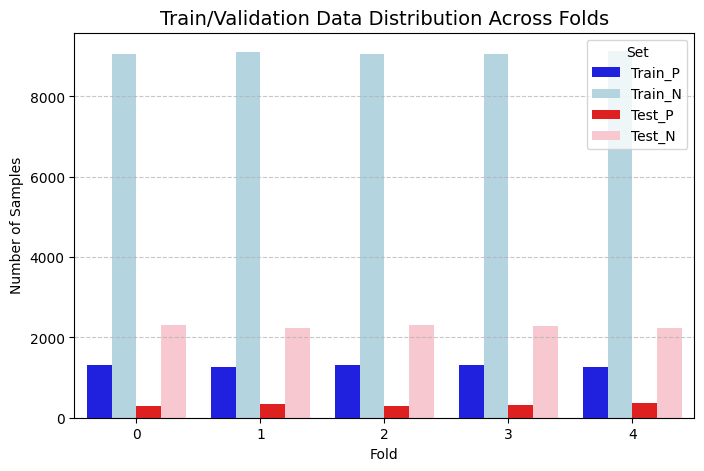

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GroupKFold
from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score, recall_score

def kfold_cv_by_group(X: pd.DataFrame, y: pd.Series, groups: pd.Series, model: BaseEstimator, **kwargs) -> pd.DataFrame:
    group_kfold = GroupKFold(**kwargs)

    scores = {'fold': [], 'auc': [], 'rec': []}
    fold_data = {'Fold': [], 'Set': [], 'Size': []}

    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X, y, groups)):
        print(f'Performing on {fold=}')
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        auc_score = roc_auc_score(y_val, y_pred)
        rec_score = recall_score(y_val, y_pred)
        
        scores['fold'].append(fold)
        scores['auc'].append(auc_score)
        scores['rec'].append(rec_score)  # TPR

        fold_data['Fold'].extend([fold, fold, fold, fold])  # Add fold index twice
        fold_data['Set'].extend(['Train_P', 'Train_N', 'Test_P', 'Test_N'])  # Train and Test labels
        fold_data['Size'].extend([len(y_train[y_train == 1]), len(y_train[y_train == 0]), 
                                  len(y_val[y_val == 1]), len(y_val[y_val == 0])])  # Number of samples
        print(fold_data['Size'])
    
    # Convert to DataFrame
    fold_df = pd.DataFrame(fold_data)

    # Create bar plot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=fold_df, x="Fold", y="Size", hue="Set", palette=['blue', 'lightblue', 'red', 'pink'], dodge='auto')

    # Customize plot
    plt.title("Train/Validation Data Distribution Across Folds", fontsize=14)
    plt.xlabel("Fold")
    plt.ylabel("Number of Samples")
    plt.legend(title="Set", loc="upper right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    return pd.DataFrame(scores)

non_feature_cols = ['domain', 'aa_ProtPosition', 'uniprot_id']
X = remove_non_features(X_tv, non_feature_cols)
y = y_tv
groups = X_tv.uniprot_id

baseline_model = DecisionTreeClassifier(class_weight='balanced')

baseline_scores = kfold_cv_by_group(X, y, groups, baseline_model)

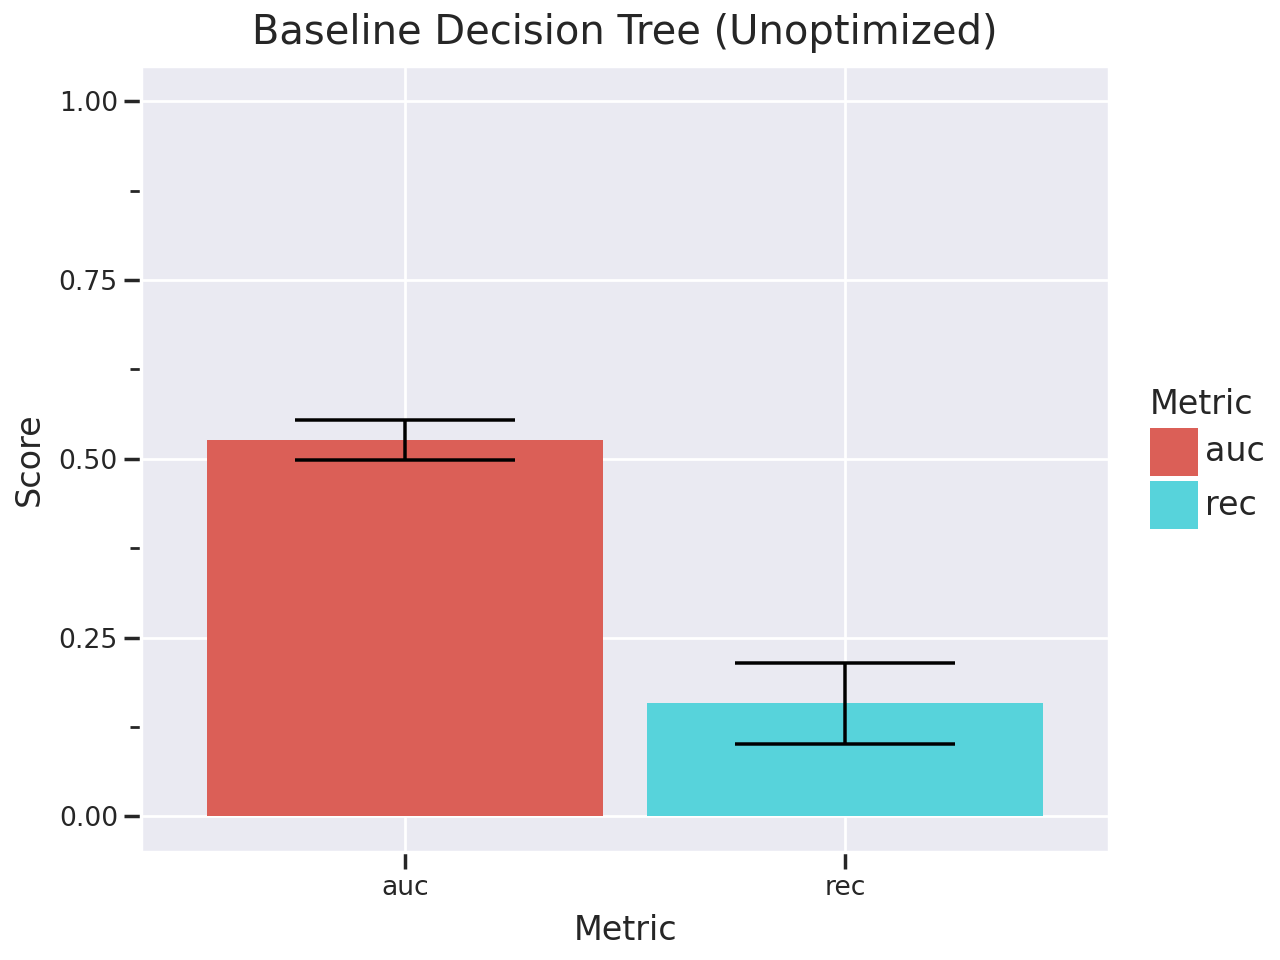

In [16]:
from plotnine import ggplot, aes, geom_bar, geom_errorbar, labs, theme_seaborn, ylim

def plot_performance(df: pd.DataFrame, score_names: list, title: str='') -> None:

    df_long = df.melt(value_vars=['auc', 'rec'], var_name='Metric', value_name='Score')
    score_means = df[score_names].mean()
    score_stds = df[score_names].std()
    score_summary = pd.DataFrame({
        'Metric': score_means.index,
        'Mean': score_means.values,
        'StDev': score_stds.values
    })
    df_long = df_long.merge(score_summary, on='Metric', how='left')

    # Create ggplot
    p = (
        ggplot(df_long, aes(x='Metric', y='Mean', fill='Metric')) +
        geom_bar(stat='identity', position='dodge', show_legend=True) +  # Bar plot
        labs(title=title, y="Score", x="Metric") +
        geom_errorbar(aes(ymin='Mean - StDev', ymax='Mean + StDev')) +
        ylim(0,1) +
        theme_seaborn()
    )

    display(p)

plot_performance(baseline_scores, ['auc', 'rec'], 'Baseline Decision Tree (Unoptimized)')

In [17]:
from sklearn.model_selection import GridSearchCV
# Grid search optimization
gs_params = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth': [5, 7, 10, 12, 15, 20],
    'min_samples_leaf': [4, 8, 12, 14, 16, 18, 20, 24, 32]
}  # min_samples_split was omitted because it didn't have a big impact on performance
gs_model = DecisionTreeClassifier(class_weight='balanced')
gridsearch = GridSearchCV(gs_model, param_grid=gs_params, n_jobs=-1, scoring='roc_auc', cv=GroupKFold())

gridsearch.fit(X, y, groups=groups)
print(gridsearch.best_params_, 'with score: ', gridsearch.best_score_)

{'criterion': 'log_loss', 'max_depth': 7, 'min_samples_leaf': 8} with score:  0.6136264178249972


In [20]:
pd.DataFrame(gridsearch.cv_results_).sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
118,0.407000,0.018013,0.004926,0.000352,log_loss,7,8,"{'criterion': 'log_loss', 'max_depth': 7, 'min...",0.625403,0.603048,0.684330,0.661433,0.493918,0.613626,0.066129,1
64,0.408273,0.011741,0.004850,0.000315,entropy,7,8,"{'criterion': 'entropy', 'max_depth': 7, 'min_...",0.625873,0.603048,0.681241,0.661433,0.495059,0.613331,0.065080,2
62,0.296980,0.013854,0.004654,0.000308,entropy,5,32,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.608922,0.565295,0.697818,0.672358,0.521713,0.613221,0.065334,3
116,0.296328,0.012478,0.005539,0.001133,log_loss,5,32,"{'criterion': 'log_loss', 'max_depth': 5, 'min...",0.608922,0.565295,0.697818,0.672358,0.521713,0.613221,0.065334,3
120,0.400306,0.013817,0.005157,0.000410,log_loss,7,14,"{'criterion': 'log_loss', 'max_depth': 7, 'min...",0.623704,0.598246,0.681066,0.670644,0.491192,0.612971,0.068008,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.656541,0.041187,0.005872,0.000717,log_loss,12,4,"{'criterion': 'log_loss', 'max_depth': 12, 'mi...",0.522075,0.551546,0.597639,0.592630,0.475712,0.547920,0.045532,158
153,0.769368,0.049793,0.005576,0.000978,log_loss,20,4,"{'criterion': 'log_loss', 'max_depth': 20, 'mi...",0.546917,0.545963,0.585188,0.549462,0.507736,0.547053,0.024524,159
99,0.764472,0.018678,0.005588,0.001121,entropy,20,4,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.542497,0.535781,0.580393,0.546023,0.499593,0.540857,0.025772,160
90,0.681853,0.029278,0.005950,0.001018,entropy,15,4,"{'criterion': 'entropy', 'max_depth': 15, 'min...",0.538556,0.533506,0.574969,0.573104,0.480825,0.540192,0.034247,161


{'criterion': 'log_loss', 'max_depth': 7, 'min_samples_leaf': 8}
Performing on fold=0
[1318, 9057, 301, 2297]
Performing on fold=1
[1318, 9057, 301, 2297, 1269, 9112, 350, 2242]
Performing on fold=2
[1318, 9057, 301, 2297, 1269, 9112, 350, 2242, 1325, 9055, 294, 2299]
Performing on fold=3
[1318, 9057, 301, 2297, 1269, 9112, 350, 2242, 1325, 9055, 294, 2299, 1313, 9062, 306, 2292]
Performing on fold=4
[1318, 9057, 301, 2297, 1269, 9112, 350, 2242, 1325, 9055, 294, 2299, 1313, 9062, 306, 2292, 1251, 9130, 368, 2224]


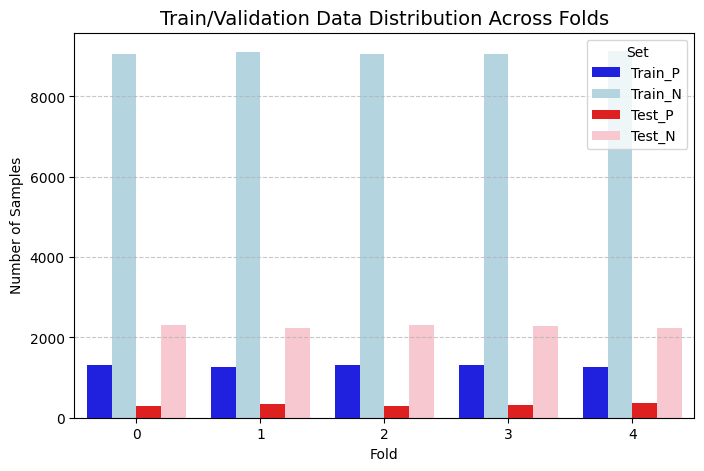

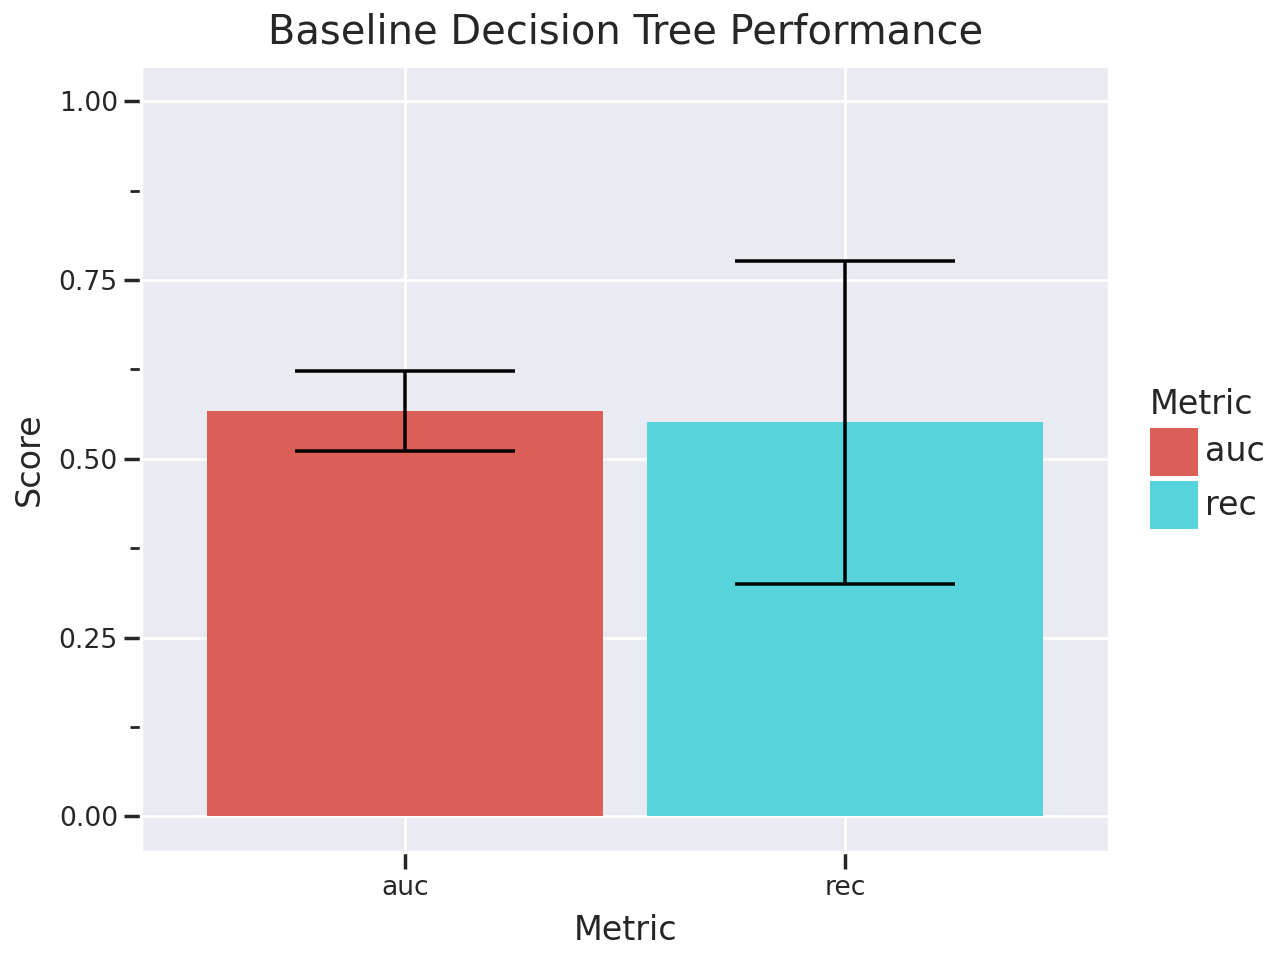

In [21]:
# Train optimized DT
baseline_model = DecisionTreeClassifier(class_weight='balanced', **gridsearch.best_params_)
print(gridsearch.best_params_)

baseline_scores = kfold_cv_by_group(X, y, groups, baseline_model)

plot_performance(baseline_scores, ['auc', 'rec'], 'Baseline Decision Tree Performance')